# embeddings-figure
6.17.24     
Load a pre-baked Lupine model. Then make a UMAP for the learned protein
embeddings. Unfortunately this still requires a CUDA device. This wasn't trained on the normalized 
version of the joint quants matrix....should go back and redo this analysis for a Lupine model trained
on the normalized joint quants matrix. 

In [1]:
import pandas as pd 
import numpy as np
import torch
import sys
import umap
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import sklearn.cluster as cluster

from matplotlib.colors import LinearSegmentedColormap

# Import my utils module
sys.path.append("../../../bin/")
from utils import *

# And my imputation models
sys.path.append("../../../bin/models/")
from lupine_models import Lupine

# plotting templates
sns.set(context="talk", style="ticks") 
sns.set_palette("tab10")

/net/noble/vol2/home/lincolnh/miniconda3/envs/deep-impute/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


#### Configs

In [2]:
# Paths for the component quants matrices
datasets_stem="/net/noble/vol2/home/lincolnh/data/quant-data/UMich-quants-matrices/"
joint_fname="joint-quants-matrix-umich.csv"
tail="_report_abundance_groupby=protein_protNorm=MD_gu=2.tsv"

# The pre-built metadata path
meta_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-05-10_metadata_mapping/meta-dict.csv"

cohorts=["BRCA", "CCRCC", "COAD", "GBM", "HGSC", 
         "HNSCC", "LSCC", "LUAD", "PDAC", "UCEC"]

# Partitioning params
val_frac=0.15
test_frac=0.0
min_pres=0
rand_state=18

# Model training params
lr=0.001
tol=0.0001
epochs=3
patience=10
device="cuda"
batch_size=128
rand_seed=18
n_prot_factors=12
n_run_factors=12
n_layers=1
n_nodes=32

# UMAP configs
#   A lower value of `k_neighbors` will prioritize local structure, a 
#   higher value will prioritize global structure
k_neighbors=16
min_dist=0.2
rand_state=42

# Path to the pre-baked model. This could really be any pre-trained model
MODEL_PATH="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-04-01_postop/OPT_MODEL_INTERNAL.pt"

#### Read in the joint quants matrix

In [3]:
joint_mat = pd.read_csv(datasets_stem+joint_fname, index_col=0)
joint = np.array(joint_mat)

#### Map the CPTAC run IDs to their cohorts

In [4]:
to_remove = ["Index", "NumberPSM", "Gene", "MaxPepProb", 
             "ReferenceIntensity"]
runs_x_cohorts = {}

for cohort in cohorts: 
    f_path = datasets_stem + cohort + tail
    curr_file = pd.read_csv(f_path, sep="\t")
    curr_file = curr_file.drop(to_remove, axis=1)
    curr_runs = list(curr_file.columns)

    cohort_id = cohort.split("_")[0]
    
    for curr_run in curr_runs:
        runs_x_cohorts[curr_run] = cohort_id

#### MCAR partition the joint quants matrix

In [5]:
train, val, test, discard = \
    mcar_partition(
        matrix=joint, 
        val_frac=val_frac, 
        test_frac=test_frac, 
        min_present=min_pres, 
        random_state=rand_seed,
    )

#### Load the pre-trained model and transform the train set

In [6]:
# Init the model 
model = Lupine(  
            n_prots=train.shape[0],
            n_runs=train.shape[1], 
            n_prot_factors=n_prot_factors,
            n_run_factors=n_run_factors,
            n_layers=n_layers,
            n_nodes=n_nodes,
            learning_rate=lr,
            batch_size=batch_size,
            tolerance=tol,
            max_epochs=epochs,
            patience=patience,
            biased=False,
            device=device,
)
# Load the model 
model = torch.load(MODEL_PATH)
model.eval()

# Transform
model_recon = model.transform(train, val)

Loading tensors on:  cuda
Number of parameters: 252605


#### Run UMAP on the protein embeddings
And save to a dataframe, and append the missingness information. 

In [7]:
# Extract the protein embeddings
embs = model.prot_factors.detach().cpu().numpy()

# Init UMAP
umapper = umap.UMAP(
            n_neighbors=16,
            min_dist=1.0,
            n_components=2,
            random_state=42,
)
# Run UMAP
clust_emb = umapper.fit_transform(embs)

# Init a dataframe to hold results
umap_df = pd.DataFrame(columns=["protID", "UMAP1", "UMAP2", "mv_frac"])

# Fill in 
umap_df["protID"] = list(joint_mat.index)
umap_df["UMAP1"] = clust_emb[:,0]
umap_df["UMAP2"] = clust_emb[:,1]

# Get the missingness fractions
nan_count = joint_mat.isnull().sum(axis=1)
nan_frac = list(nan_count / joint_mat.shape[1])

umap_df["mv_frac"] = nan_frac

---
## Add in the run embeddings

#### UMAP on the trained model's run embeddings

In [8]:
# Extract the protein embeddings
run_embs = model.run_factors.detach().cpu().numpy()

# Init UMAP
umapper1 = umap.UMAP(
            n_neighbors=16,
            min_dist=1.0,
            n_components=2,
            random_state=42,
)
# Run UMAP
run_emb = umapper.fit_transform(run_embs.T)

# Init a dataframe to hold results
run_umap_df = pd.DataFrame(columns=["runID", "UMAP1", "UMAP2"])

# # Fill in 
run_umap_df["runID"] = list(joint_mat.columns)
run_umap_df["UMAP1"] = run_emb[:,0]
run_umap_df["UMAP2"] = run_emb[:,1]

#### Add in the cohort IDs

In [9]:
_cohorts = []
for rid in run_umap_df["runID"]:
    _cohort = runs_x_cohorts[rid]
    _cohorts.append(_cohort)
    
run_umap_df["Cohort"] = _cohorts

#### Define the color map

In [10]:
color1 = '#1f77b4' # tab10 blue
color2 = '#ff7f0e' # tab10 orange
cmap = LinearSegmentedColormap.from_list('mycmap', [color1, color2])

#### Plot side-by-side

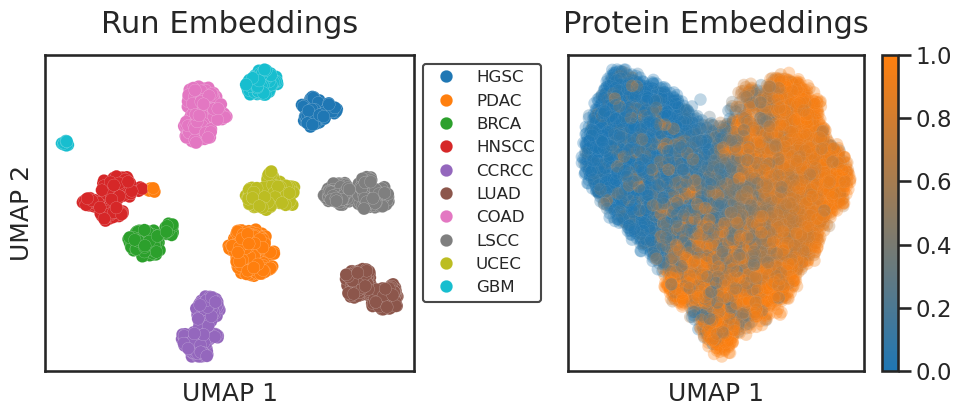

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4.5))

# RUN EMBEDDINGS
sns.scatterplot(
    data=run_umap_df,
    x="UMAP1",
    y="UMAP2",
    alpha=1.0,
    hue="Cohort",
    palette="tab10",
    linewidth=0.1,
    ax=ax1,
)

ax1.set_title("Run Embeddings", pad=16, size=22)
ax1.set_xlabel("UMAP 1", labelpad=8)
ax1.set_ylabel("UMAP 2", labelpad=8)

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.get_legend().remove()

ax1.legend(bbox_to_anchor=(1.0, 1.0), edgecolor="k", prop={'size': 12})

# PROTEIN EMBEDDINGS
sns.scatterplot(
        data=umap_df, 
        x="UMAP1", 
        y="UMAP2", 
        alpha=0.3,
        hue="mv_frac", 
        palette=cmap,
        linewidth=0.1,
        ax=ax2
)
ax2.set_title("Protein Embeddings", pad=16, size=22)
ax2.set_xlabel("UMAP 1", labelpad=8)
ax2.set_ylabel("")

ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])

ax2.get_legend().remove()

norm = plt.Normalize(0.0, 1.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ax2.figure.colorbar(sm, ax=ax2)
#ax2.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

plt.tight_layout()
plt.show()
#plt.savefig("figures/lupine-embeddings-figure.pdf", bbox_inches="tight")

---
## Fuck with metadata

#### Read in the pre-built metadata csv

In [12]:
meta_dict = pd.read_csv(meta_path)

#### Map on the sample types to each aliquot ID

In [13]:
sample_types = []

for idx in range(0, run_umap_df.shape[0]):
    curr_row = run_umap_df.iloc[idx]
    curr_run = curr_row["runID"]

    if curr_run in list(meta_dict["aliquot_ID"]):
        meta_row = meta_dict[meta_dict["aliquot_ID"] == curr_run]
        sample_type = meta_row["sample_type"].item()
    else:
        sample_type = np.nan

    sample_types.append(sample_type)

run_umap_df["sampleTypes"] = sample_types

#### Discard the runs that we no longer care about 
This should really be done *before* the UMAP. 

In [14]:
# Remove some of these extraneous runs
keywords = ["RefInt", "QC", "pool", "Tumor", "Pooled", 
            "Pool", "Reference", "NCI", "NX", "Ref"]
to_drop = []

for sample_id in list(run_umap_df["runID"]):
    exclude=False
    for kw in keywords:
        if kw in sample_id:
            exclude=True
            break
    to_drop.append(exclude)

run_umap_df = run_umap_df[~np.array(to_drop)]
run_umap_df = run_umap_df.reset_index(drop=True)
print(run_umap_df.shape)

(1755, 5)


#### Standardize the sample type labels

In [15]:
for idx in range(0, run_umap_df.shape[0]):
    curr_row = run_umap_df.iloc[idx]
    if curr_row["sampleTypes"] == "Primary Tumor":
        new_str = "Tumor"
    elif curr_row["sampleTypes"] == "Solid Tissue Normal":
        new_str = "Non-tumor"
    elif curr_row["sampleTypes"] == "Not Reported":
        new_str = np.nan
    elif curr_row["sampleTypes"] == "Unknown":
        new_str = np.nan
    elif curr_row["sampleTypes"] == "C":
        new_str = np.nan

    run_umap_df.loc[idx, "sampleTypes"] = new_str

#### Plot, coloring by tumor/normal status

/tmp/2840256.1.noble-login.q/ipykernel_674976/1146588952.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg1.legendHandles:
/tmp/2840256.1.noble-login.q/ipykernel_674976/1146588952.py:59: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg2.legendHandles:


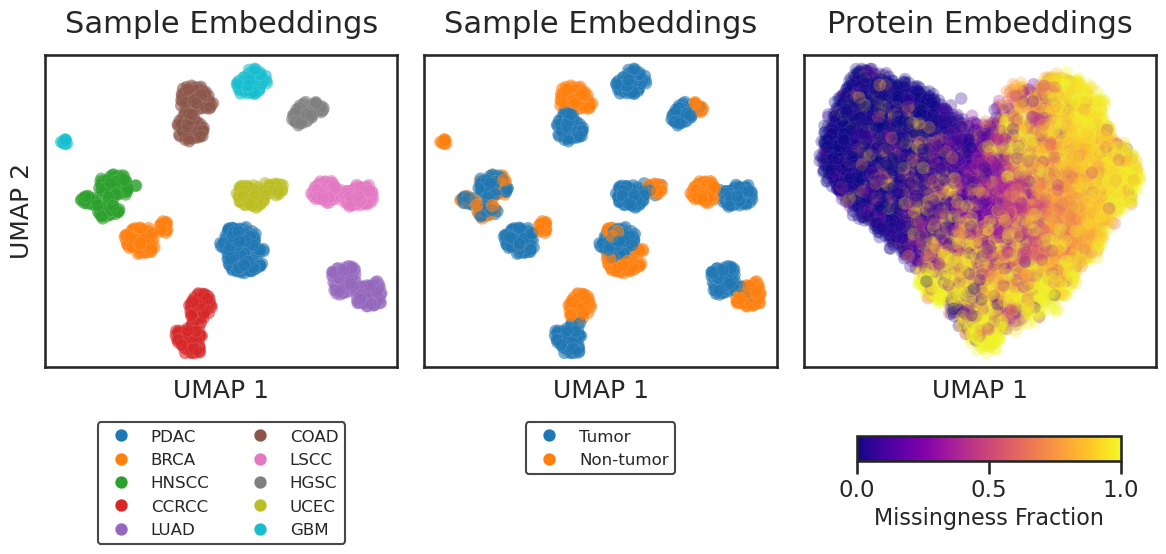

In [20]:
pal1 = ["#2ca02c", "#d62728"]
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,6.25))

# RUN EMBEDDINGS -- BY COHORT
sns.scatterplot(
    data=run_umap_df,
    x="UMAP1",
    y="UMAP2",
    alpha=0.6,
    hue="Cohort",
    palette="tab10",
    linewidth=0.1,
    ax=ax1,
)
ax1.set_title("Sample Embeddings", pad=16, size=22)
ax1.set_xlabel("UMAP 1", labelpad=8)
ax1.set_ylabel("UMAP 2", labelpad=8)

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.get_legend().remove()

leg1 = ax1.legend(
            loc="upper center", 
            bbox_to_anchor=(0.5, -0.15), 
            fancybox=True,
            edgecolor="k", 
            prop={"size":12}, ncol=2,
)
for lh in leg1.legendHandles: 
    lh.set_alpha(1)

# RUN EMBEDDINGS -- BY SAMPLE TYPE
sns.scatterplot(
    data=run_umap_df,
    x="UMAP1",
    y="UMAP2",
    alpha=0.6,
    hue="sampleTypes",
    palette="tab10",
    linewidth=0.1,
    ax=ax2,
)
ax2.set_title("Sample Embeddings", pad=16, size=22)
ax2.set_xlabel("UMAP 1", labelpad=8)
ax2.set_ylabel("", labelpad=8)

ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax2.get_legend().remove()

leg2 = ax2.legend(
            loc="upper center", 
            bbox_to_anchor=(0.5, -0.15), 
            fancybox=True,
            edgecolor="k", 
            prop={"size":12},
)
for lh in leg2.legendHandles: 
    lh.set_alpha(1)
    
# PROTEIN EMBEDDINGS
sns.scatterplot(
        data=umap_df, 
        x="UMAP1", 
        y="UMAP2", 
        alpha=0.3,
        hue="mv_frac", 
        palette="plasma",
        linewidth=0.1,
        ax=ax3
)
ax3.set_title("Protein Embeddings", pad=16, size=22)
ax3.set_xlabel("UMAP 1", labelpad=8)
ax3.set_ylabel("")

ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])

ax3.get_legend().remove()

norm = plt.Normalize(0.0, 1.0)
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
#ax3.figure.colorbar(sm, ax=ax3, location="bottom")
cax = ax3.inset_axes([0.15, -0.3, 0.75, 0.08])
ax3.figure.colorbar(sm, ax=ax3, orientation="horizontal", cax=cax).set_label(label="Missingness Fraction", size=16)

plt.tight_layout()
#plt.show()
plt.savefig("../figures/lupine-embeddings-figure-v2.pdf", bbox_inches="tight")

---
## Explore some alternative color palettes

#### Define some new color palettes

In [17]:
full_pal = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99',
        '#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
two_tone_pal = ["#ff7f00", "#1f78b4"]

color1 = '#6a3d9a' 
color2 = '#a6cee3' 
diverge_map = LinearSegmentedColormap.from_list('mycmap', [color1, color2])

#### Plot

/tmp/2840256.1.noble-login.q/ipykernel_674976/1166756378.py:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg1.legendHandles:
/tmp/2840256.1.noble-login.q/ipykernel_674976/1166756378.py:58: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg2.legendHandles:


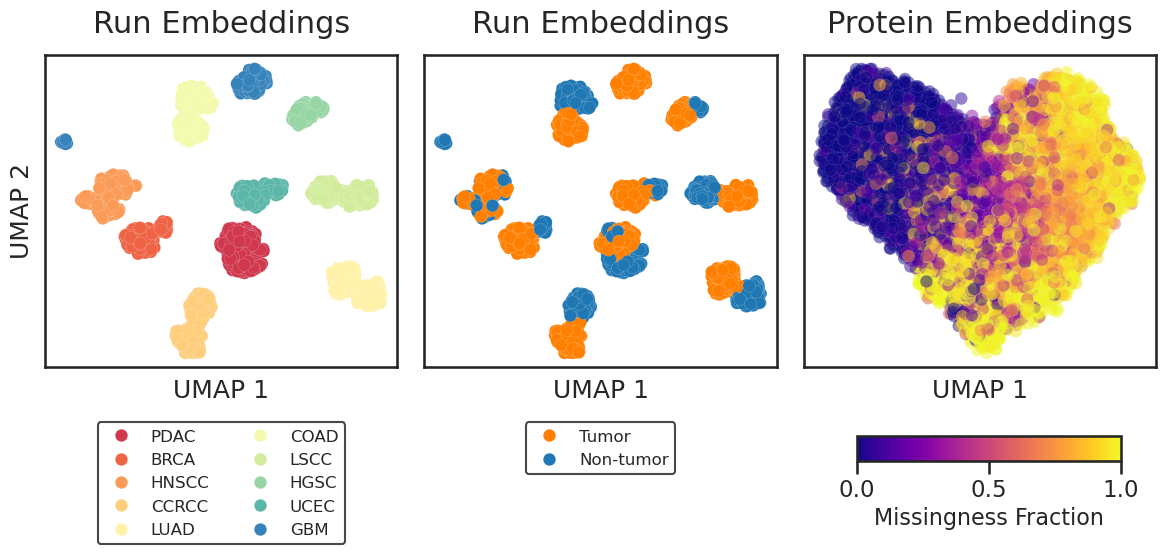

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,6.25))

# RUN EMBEDDINGS -- BY COHORT
sns.scatterplot(
    data=run_umap_df,
    x="UMAP1",
    y="UMAP2",
    alpha=1.0,
    hue="Cohort",
    palette="Spectral",
    linewidth=0.1,
    ax=ax1,
)
ax1.set_title("Run Embeddings", pad=16, size=22)
ax1.set_xlabel("UMAP 1", labelpad=8)
ax1.set_ylabel("UMAP 2", labelpad=8)

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.get_legend().remove()

leg1 = ax1.legend(
            loc="upper center", 
            bbox_to_anchor=(0.5, -0.15), 
            fancybox=True,
            edgecolor="k", 
            prop={"size":12}, ncol=2,
)
for lh in leg1.legendHandles: 
    lh.set_alpha(1)

# RUN EMBEDDINGS -- BY SAMPLE TYPE
sns.scatterplot(
    data=run_umap_df,
    x="UMAP1",
    y="UMAP2",
    alpha=1.0,
    hue="sampleTypes",
    palette=two_tone_pal,
    linewidth=0.1,
    ax=ax2,
)
ax2.set_title("Run Embeddings", pad=16, size=22)
ax2.set_xlabel("UMAP 1", labelpad=8)
ax2.set_ylabel("", labelpad=8)

ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax2.get_legend().remove()

leg2 = ax2.legend(
            loc="upper center", 
            bbox_to_anchor=(0.5, -0.15), 
            fancybox=True,
            edgecolor="k", 
            prop={"size":12},
)
for lh in leg2.legendHandles: 
    lh.set_alpha(1)
    
# PROTEIN EMBEDDINGS
sns.scatterplot(
        data=umap_df, 
        x="UMAP1", 
        y="UMAP2", 
        alpha=0.5,
        hue="mv_frac", 
        palette="plasma",
        linewidth=0.1,
        ax=ax3
)
ax3.set_title("Protein Embeddings", pad=16, size=22)
ax3.set_xlabel("UMAP 1", labelpad=8)
ax3.set_ylabel("")

ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])

ax3.get_legend().remove()

norm = plt.Normalize(0.0, 1.0)
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
#ax3.figure.colorbar(sm, ax=ax3, location="bottom")
cax = ax3.inset_axes([0.15, -0.3, 0.75, 0.08])
ax3.figure.colorbar(sm, ax=ax3, orientation="horizontal", cax=cax).set_label(label="Missingness Fraction", size=16)

plt.tight_layout()
plt.show()
#plt.savefig("../figures/lupine-embeddings-figure-v2.pdf", bbox_inches="tight")